<a href="https://colab.research.google.com/github/seb-jul/deeplearningproject/blob/main/DL_Hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Projet Deep Learning FER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv('fer2013.csv')

print(f'{df.shape}\n{df.head(1)}')
print(f'\nNumber of emotions : {len(pd.unique(df["emotion"]))}')
print(f'Usage : {pd.unique(df["Usage"])}')

Mounted at /content/drive
/content/drive/MyDrive/Projet Deep Learning FER
(35887, 3)
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training

Number of emotions : 7
Usage : ['Training' 'PublicTest' 'PrivateTest']


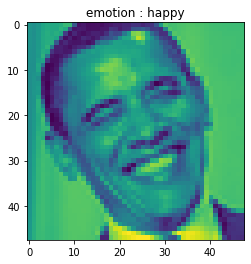

In [ ]:
#Because of the training set informations, we know that:

emotions_list = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral') # Each emotion is associated by it's index
img_size = (48,48) # 2D image size

test_sample = 10000

test_image  = np.array(df.iloc[test_sample]["pixels"].split(" "),'float32')
plt.title(f'emotion : {emotions_list[df.iloc[test_sample]["emotion"]]}')
plt.imshow(test_image.reshape(img_size))

In [ ]:
def dataPreparation(df):
  df_transformed = df.copy()

  training = df_transformed[df_transformed['Usage']=='Training']
  testing = df_transformed[df_transformed['Usage']=='PublicTest']

  X_train,X_test,Y_train,Y_test = training['pixels'].to_numpy(), testing['pixels'].to_numpy(),training['emotion'].to_numpy(),testing['emotion'].to_numpy()

  X_train = [np.array(elem.split(' '),'float32').reshape(48, 48, 1) for elem in X_train]
  X_test = [np.array(elem.split(' '),'float32').reshape(48, 48, 1) for elem in X_test]

  Y_train=np_utils.to_categorical(Y_train, num_classes=7)  
  Y_test=np_utils.to_categorical(Y_test, num_classes=7)

  X_train = np.array(X_train,'float32')
  Y_train = np.array(Y_train,'float32')  
  X_test = np.array(X_test,'float32')  
  Y_test = np.array(Y_test,'float32')

  #X_train /= 255
  #X_test /= 255

  X_train = (X_train - np.mean(X_train))/np.std(X_train)
  X_test = (X_test - np.mean(X_test))/np.std(X_test)
  
  return X_train,X_test,Y_train,Y_test

from keras.utils import np_utils  

X_train,X_test,Y_train,Y_test = dataPreparation(df)

In [ ]:
#pip install keras-tuner --upgrade

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from tensorflow.keras import optimizers
from keras.regularizers import l2  
from keras.utils import np_utils   


def build_model(hp):  
  model = keras.models.Sequential()  

  #1st convolution layer
  
  #model.add(Conv2D(hp.Int("conv_1_filter", min_value=64, max_value=128, step=64), 
                   #kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
                   #activation='relu', input_shape=(X_train.shape[1:])))
  model.add(Conv2D(64, (4,4), activation='relu', input_shape=(X_train.shape[1:])))
  #model.add(Conv2D(hp.Int("conv_2_filter", min_value=64, max_value=128, step=64), 
                   #kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
                   #activation='relu'))
  model.add(Conv2D(64, (4,4), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
  model.add(Dropout(hp.Float("dropout_1", min_value=0.3, max_value=0.5, default=0.3,step=0.1)))

  #2nd convolution layer

  model.add(Conv2D(hp.Int("conv_3_filter", min_value=64, max_value=128, step=64), 
                   kernel_size=hp.Choice('conv_3_kernel', values = [3,4]),
                   activation='relu'))
  model.add(Conv2D(hp.Int("conv_4_filter", min_value=64, max_value=128, step=64), 
                   kernel_size=hp.Choice('conv_4_kernel', values = [3,4]),
                   activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
  model.add(Dropout(hp.Float("dropout_2", min_value=0.3, max_value=0.5, default=0.3,step=0.1)))

  #3nd convolution layer

  model.add(Conv2D(hp.Int("conv_5_filter", min_value=64, max_value=128, step=64), 
                   kernel_size=hp.Choice('conv_5_kernel', values = [3,4]),
                   activation='relu'))
  model.add(Conv2D(hp.Int("conv_6_filter", min_value=64, max_value=128, step=64), 
                   kernel_size=hp.Choice('conv_6_kernel', values = [3,4]),
                   activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
  #model.add(Dropout(hp.Float("dropout_3", min_value=0.3, max_value=0.5, default=0.3,step=0.1)))

  model.add(Flatten())  
  
  #fully connected neural networks  
  model.add(Dense(hp.Int("dense_1_unit", min_value=512, max_value=1024, step=512), activation='relu'))
  model.add(Dropout(0.2))  
  model.add(Dense(hp.Int("dense_2_unit", min_value=512, max_value=1024, step=512), activation='relu'))
  model.add(Dropout(0.2))  
  
  model.add(Dense(len(emotions_list), activation='softmax'))
  
  #Compliling the model  
  model.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                metrics=['accuracy'])  
  
  return model

In [ ]:
tuner = kt.RandomSearch(build_model,
                        objective = 'val_accuracy', 
                        max_trials = 150,
                        directory = 'Finding_best_3_layer_model',
                        project_name = 'Entrainement_matin_1_10/12') 
                     
tuner.search(X_train, Y_train, epochs = 15, validation_data = (X_test, Y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', min_delta=0.01, patience=4)])

# Which was the best model?
best_model = tuner.get_best_models(1)[0]

# What were the best hyperparameters?
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
# Which was the best model?
best_model = tuner.get_best_models(1)[0]

# What were the best hyperparameters?
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
#Saving the best model to use it later on  
fer_json = best_model.to_json()  
with open("meilleur_modele_10_dec_3_layers.json", "w") as json_file:  
    json_file.write(fer_json)  
best_model.save_weights("meilleur_modele_10_dec_3_layers.h5")

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer=optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])

model.fit(X_train, Y_train,batch_size=32,epochs=15,validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/15
898/898 [==============================] - 11s 12ms/step - loss: 0.8864 - accuracy: 0.6684 - val_loss: 1.1083 - val_accuracy: 0.5996
Epoch 2/15
898/898 [==============================] - 10s 11ms/step - loss: 0.8554 - accuracy: 0.6808 - val_loss: 1.0996 - val_accuracy: 0.5943
Epoch 3/15
898/898 [==============================] - 10s 11ms/step - loss: 0.8245 - accuracy: 0.6941 - val_loss: 1.0826 - val_accuracy: 0.6041
Epoch 4/15
898/898 [==============================] - 10s 11ms/step - loss: 0.7978 - accuracy: 0.7059 - val_loss: 1.0969 - val_accuracy: 0.6135
Epoch 5/15
898/898 [==============================] - 10s 11ms/step - loss: 0.7770 - accuracy: 0.7089 - val_loss: 1.1199 - val_accuracy: 0.6121
Epoch 6/15
898/898 [==============================] - 10s 11ms/step - loss: 0.7432 - accuracy: 0.7237 - val_loss: 1.1307 - val_accuracy: 0.6049
Epoch 7/15
898/898 [==============================] - 10s 11ms/step - loss: 0.7244 - accuracy: 0.7322 - val_loss: 1.1700 - val_accuracy:

In [ ]:
from keras.initializers import glorot_uniform
import tensorflow as tf
from sklearn.metrics import accuracy_score
#Reading the model from JSON file
with open('meilleur_modele_10_dec_3_layers.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('meilleur_modele_10_dec_3_layers.h5')

predict_x  = model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

accuracy_score([np.argmax(elem) for elem in Y_test],classes_x)

0.5979381443298969

{y:"angry",angry:257,disgust:4,fear:41,happy:36,sad:61,surprise:15,neutral:53},
{y:"disgust",angry:22,disgust:15,fear:9,happy:2,sad:3,surprise:1,neutral:4},
{y:"fear",angry:63,disgust:0,fear:164,happy:33,sad:93,surprise:72,neutral:71},
{y:"happy",angry:27,disgust:0,fear:14,happy:754,sad:16,surprise:36,neutral:48},
{y:"sad",angry:82,disgust:1,fear:72,happy:72,sad:269,surprise:23,neutral:134},
{y:"surprise",angry:14,disgust:0,fear:20,happy:20,sad:8,surprise:342,neutral:11},
{y:"neutral",angry:46,disgust:1,fear:39,happy:76,sad:87,surprise:13,neutral:345},


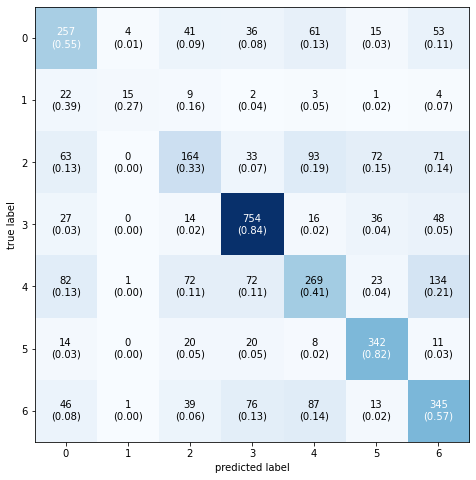

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix([np.argmax(elem) for elem in Y_test],classes_x)
plot_confusion_matrix(conf_mat = mat, figsize=(8,8), show_normed = True)
i=0
for elem in mat:
  print('{y:"'+emotions_list[i]+'",'+emotions_list[0]+':'+str(elem[0])+','+emotions_list[1]+':'+str(elem[1])+','+emotions_list[2]+':'+str(elem[2])+','+emotions_list[3]+':'+str(elem[3])+','+emotions_list[4]+':'+str(elem[4])+','+emotions_list[5]+':'+str(elem[5])+','+emotions_list[6]+':'+str(elem[6])+'},')
  i+=1


In [ ]:
%cd /content/drive/MyDrive/Projet Deep Learning FER/Images test

/content/drive/MyDrive/Projet Deep Learning FER/Images test


<CascadeClassifier 0x7f29e010a610>
(1, 48, 48, 1)
Emotion found: angry with 100.0% of precision


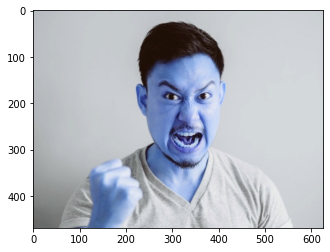

In [ ]:
import cv2
from keras.preprocessing import image

#neutral.png
#happy_test.jpg#SmilingGirl
#angry.jpg
#sad.png
#disguss.png
#surprise.png
#fear.png

img = cv2.imread('angry.jpg')
plt.imshow(img)
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print(face_cascade)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
for (x,y,w,h) in faces:
  roi_gray=gray[y:y+w,x:x+h]
  roi_gray=cv2.resize(roi_gray,(48,48))
  img_pixels = image.img_to_array(roi_gray)  
  img_pixels = np.expand_dims(img_pixels, axis = 0) 
print(img_pixels.shape)
print(f'Emotion found: {emotions_list[np.argmax(model.predict(img_pixels))]} with {np.max(model.predict(img_pixels))*100}% of precision')